# Datset: Pairwise approach

Get tracksters from a certain neighbourhood.

Neighbourhood:
- get links from ticlNtuplizer/graph
    - figure out how these links are formed

Graph:
- linked_inners
    - nodes linked to the given tracksters within its cone


In [2]:
import numpy as np
import awkward as ak

from matplotlib.ticker import FormatStrFormatter

from reco.datasetPU import get_event_pairs
from reco.event import get_bary_data, get_event_data

# plotting config
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size': 12})
rc('mathtext',**{'default':'regular'})
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

ds_name = "MultiParticle"
file_name = "new_ntuples_15163313_1.root"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"
file_path = f"{raw_dir}/{file_name}"

# data_root = "/mnt/ceph/users/ecuba/processed"
# raw_dir = f"/mnt/ceph/users/ecuba/{ds_name}"

In [3]:
cluster_data, trackster_data, simtrackster_data, assoc_data = get_event_data(file_path)

## Candidate pairs

Compile a list of candidate pairs based on the CLUE3D graph and node distance.

Reject all nodes with above a distance threshold.

In [102]:
eid = 0
dX, dY, _pair_index = get_event_pairs(
    cluster_data,
    trackster_data,
    simtrackster_data,
    assoc_data,
    eid,
    20,
    pileup=False,
    bigT_e_th=50
)


pair_index = np.array(_pair_index)
pos_index = np.array(dY) >= 0.5
neg_index = np.array(dY) < 0.5

# for i, p in  enumerate(_pair_index):
#     print(p, dY[i])

print(sum(pos_index), sum(neg_index))

46 169


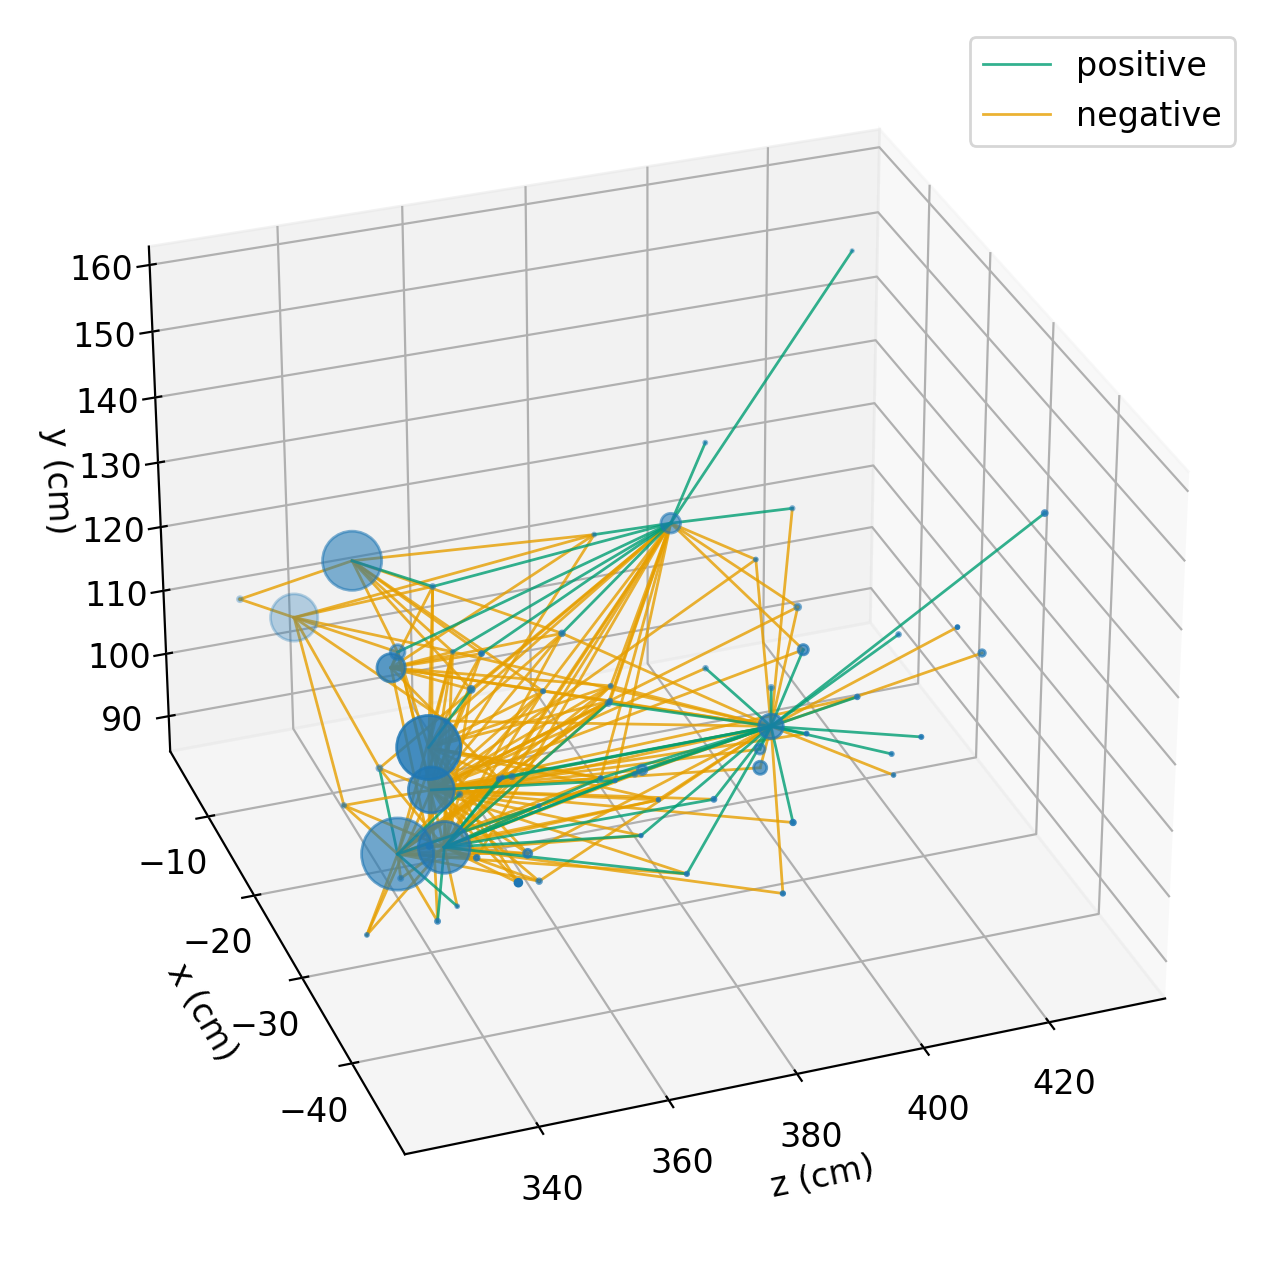

In [103]:
positive = pair_index[pos_index]
negative = pair_index[neg_index]

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(111, projection='3d')

all_tx = list(set(ak.flatten(positive).tolist() + ak.flatten(negative).tolist()))

bary = get_bary_data(trackster_data, eid)
ax1.scatter(bary[:,2][all_tx], bary[:,0][all_tx], bary[:,1][all_tx], s=trackster_data["raw_energy"][eid][all_tx])

pos_edges = []
neg_edges = []

def plot_edge(ax, edge, color, label=None):
    a, b = edge
    ca = bary[a]
    cb = bary[b]
    x = (ca[0], cb[0])
    y = (ca[1], cb[1])
    z = (ca[2], cb[2])
    ax.plot(z, x, y, c=color, linewidth=1, alpha=0.8, label=label) 


plot_edge(ax1, positive[0], "#009E73", "positive")
if len(negative):
    plot_edge(ax1, negative[0], "#E69F00", "negative")
    [plot_edge(ax1, edge, "#E69F00") for edge in negative[1:]]

[plot_edge(ax1, edge, "#009E73") for edge in positive[1:]]

ax1.set_xlabel("z (cm)")
ax1.set_ylabel("x (cm)")
ax1.set_zlabel("y (cm)")
ax1.view_init(elev=30, azim=-110)

ax1.zaxis.set_major_formatter(FormatStrFormatter('%.0f'))


plt.legend()

# fig.savefig('export/two-pion-10cm-neighborhood.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

## Dataset

In [12]:
from reco.datasetPU import TracksterPairs

In [14]:
# would need to implement some sharding here - roughly 36 files for 1M samples
ds = TracksterPairs(
    ds_name,
    data_root,
    raw_dir,
    N_FILES=50,
    radius=10,
    bigT_e_th=30,
)
ds.y.shape

torch.Size([1437701])

## Dataset balance

- CloseByTwoPion, 10cm radius, 0.7 threshold on 1000 events: 88%
- MultiParticle, 10cm radius, 0.7 threshold on 1000 events: 51% 

In [15]:
float(sum(ds.y > 0.7) / len(ds.y))

0.5178072452545166

## Dummy evaluation

Let's talk baselines on this dataset. How good is a random guess?
How good is connecting to all nodes in a neighbourhood?

In [108]:
from reco.evaluation import pairwise_model_evaluation
from reco.dummy import DummyPleaser

In [109]:
radius_list = list(range(2, 32, 2))

In [114]:
clue3D_precision = []
clue3D_recall = []
target_precision = []
target_recall = []
naive_precision = []
naive_recall = []

for radius in radius_list:
    print("radius:", radius)
    result = pairwise_model_evaluation(
        cluster_data,
        trackster_data,
        simtrackster_data,
        assoc_data,
        DummyPleaser(),
        decision_th=0.5,
        radius=radius,
        max_events=10,
        reco_to_target=False,
        bigT_e_th=40,
    )
    clue3D = np.array(result["clue3d_to_sim"])
    clue3D_precision.append(np.mean(clue3D[:,0]))
    clue3D_recall.append(np.mean(clue3D[:,1]))

    target = np.array(result["target_to_sim"])
    target_precision.append(np.mean(target[:,0]))
    target_recall.append(np.mean(target[:,1]))

    naive = np.array(result["reco_to_sim"])
    naive_precision.append(np.mean(naive[:,0]))
    naive_recall.append(np.mean(naive[:,1]))

radius: 2
Event 0:
	clue3d_to_sim:	P: 0.85 R: 0.07 F: 0.08
	target_to_sim:	P: 0.85 R: 0.07 F: 0.08
	reco_to_sim:	P: 0.85 R: 0.07 F: 0.08
Event 1:
	clue3d_to_sim:	P: 0.78 R: 0.07 F: 0.08
	target_to_sim:	P: 0.78 R: 0.07 F: 0.09
	reco_to_sim:	P: 0.78 R: 0.07 F: 0.09
Event 2:
	clue3d_to_sim:	P: 0.93 R: 0.14 F: 0.17
	target_to_sim:	P: 0.93 R: 0.14 F: 0.17
	reco_to_sim:	P: 0.93 R: 0.14 F: 0.17
Event 3:
	clue3d_to_sim:	P: 0.82 R: 0.10 F: 0.12
	target_to_sim:	P: 0.82 R: 0.10 F: 0.12
	reco_to_sim:	P: 0.82 R: 0.10 F: 0.12
Event 4:
	clue3d_to_sim:	P: 0.77 R: 0.06 F: 0.07
	target_to_sim:	P: 0.77 R: 0.06 F: 0.07
	reco_to_sim:	P: 0.77 R: 0.06 F: 0.07
Event 5:
	clue3d_to_sim:	P: 0.88 R: 0.09 F: 0.12
	target_to_sim:	P: 0.88 R: 0.09 F: 0.12
	reco_to_sim:	P: 0.88 R: 0.09 F: 0.12
Event 6:
	clue3d_to_sim:	P: 0.84 R: 0.14 F: 0.17
	target_to_sim:	P: 0.83 R: 0.15 F: 0.18
	reco_to_sim:	P: 0.83 R: 0.15 F: 0.18
Event 7:
	clue3d_to_sim:	P: 0.88 R: 0.13 F: 0.16
	target_to_sim:	P: 0.88 R: 0.13 F: 0.16
	reco_to_sim

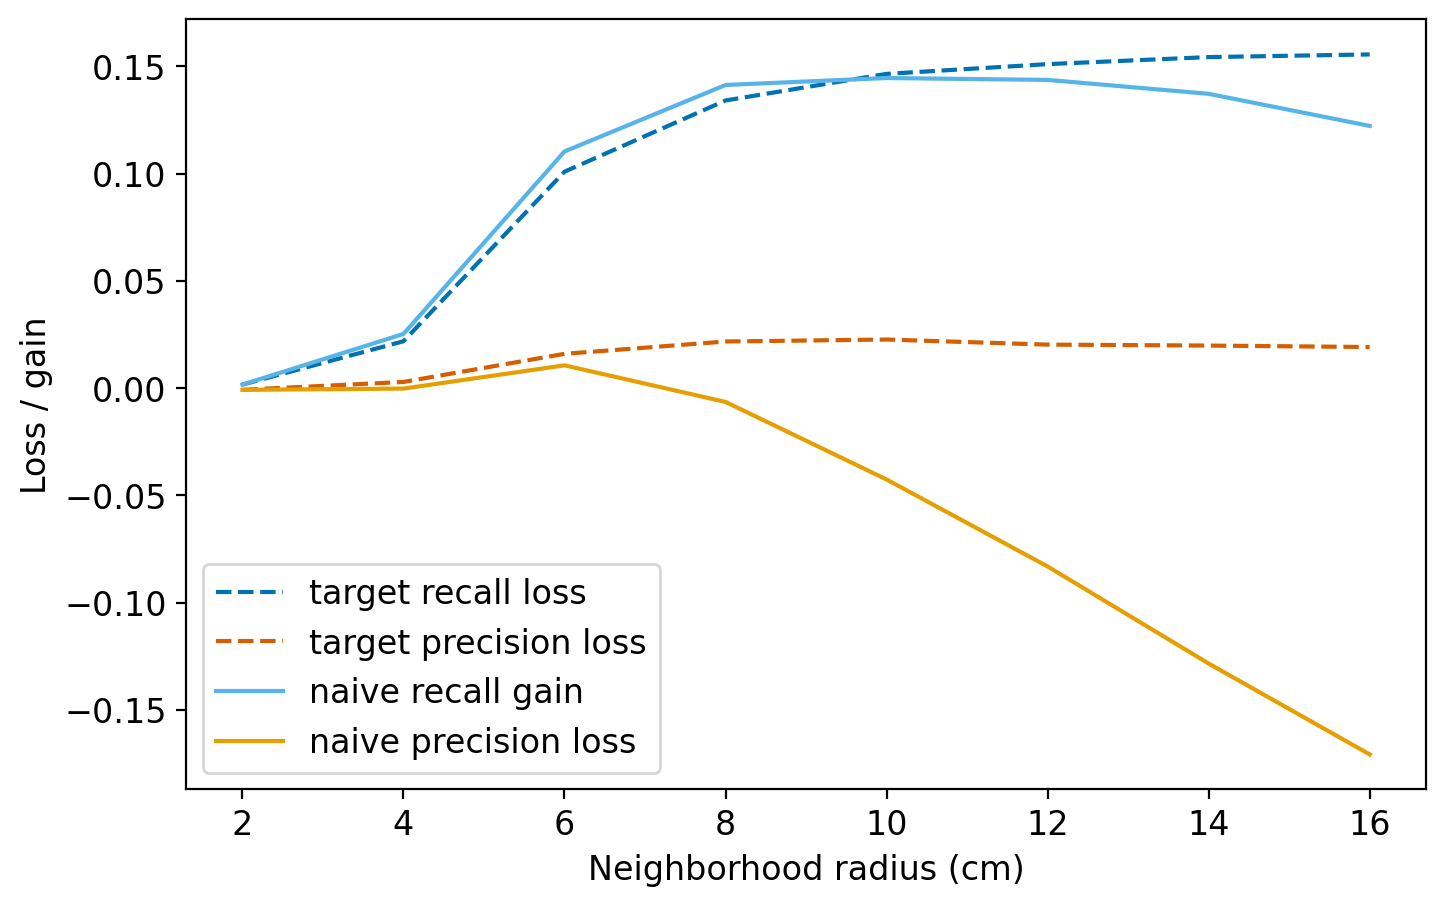

In [118]:
fig = plt.figure(figsize=(8, 5))

ax = fig.add_subplot(111)

ax.plot(radius_list[:8], (np.array(target_recall) - np.array(clue3D_recall))[:8], '--', label="target recall loss", c="#0072B2")
ax.plot(radius_list[:8], (np.array(target_precision) - np.array(clue3D_precision))[:8], '--', label="target precision loss", c="#D55E00")

ax.plot(radius_list[:8], (np.array(naive_recall) - np.array(clue3D_recall))[:8], label="naive recall gain", c="#56B4E9")
ax.plot(radius_list[:8], (np.array(naive_precision) - np.array(clue3D_precision))[:8], label="naive precision loss", c="#E69F00")


ax.legend()
ax.set_xlabel("Neighborhood radius (cm)")
ax.set_ylabel("Loss / gain")

fig.savefig('export/multiparticle-radius-plot.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [119]:

results = {}
energy_list = list(range(10, 105, 5))

for radius in [10, 20, 30]:
    clue3D_R = []
    target_R = []
    for eng in energy_list:
        print("radius:", radius, "energy:", eng)
        result = pairwise_model_evaluation(
            cluster_data,
            trackster_data,
            simtrackster_data,
            assoc_data,
            DummyPleaser(),
            decision_th=0.5,
            radius=radius,
            max_events=10,
            reco_to_target=False,
            bigT_e_th=eng,
        )
        clue3D = np.array(result["clue3d_to_sim"])
        clue3D_R.append(np.mean(clue3D[:,1]))

        target = np.array(result["target_to_sim"])
        target_R.append(np.mean(target[:,1]))
    results[radius] = (np.array(target_R), np.array(clue3D_R))

radius: 10 energy: 10
Event 0:
	clue3d_to_sim:	P: 0.85 R: 0.07 F: 0.08
	target_to_sim:	P: 0.86 R: 0.11 F: 0.13
	reco_to_sim:	P: 0.86 R: 0.15 F: 0.18
Event 1:
	clue3d_to_sim:	P: 0.78 R: 0.07 F: 0.08
	target_to_sim:	P: 0.82 R: 0.19 F: 0.22
	reco_to_sim:	P: 0.75 R: 0.15 F: 0.18
Event 2:
	clue3d_to_sim:	P: 0.93 R: 0.14 F: 0.17
	target_to_sim:	P: 0.93 R: 0.25 F: 0.30
	reco_to_sim:	P: 0.84 R: 0.23 F: 0.26
Event 3:
	clue3d_to_sim:	P: 0.82 R: 0.10 F: 0.12
	target_to_sim:	P: 0.84 R: 0.29 F: 0.33
	reco_to_sim:	P: 0.76 R: 0.27 F: 0.31
Event 4:
	clue3d_to_sim:	P: 0.77 R: 0.06 F: 0.07
	target_to_sim:	P: 0.79 R: 0.19 F: 0.23
	reco_to_sim:	P: 0.68 R: 0.19 F: 0.22
Event 5:
	clue3d_to_sim:	P: 0.88 R: 0.09 F: 0.12
	target_to_sim:	P: 0.88 R: 0.19 F: 0.22
	reco_to_sim:	P: 0.91 R: 0.21 F: 0.25
Event 6:
	clue3d_to_sim:	P: 0.84 R: 0.14 F: 0.17
	target_to_sim:	P: 0.86 R: 0.36 F: 0.40
	reco_to_sim:	P: 0.75 R: 0.29 F: 0.33
Event 7:
	clue3d_to_sim:	P: 0.88 R: 0.13 F: 0.16
	target_to_sim:	P: 0.90 R: 0.26 F: 0.30


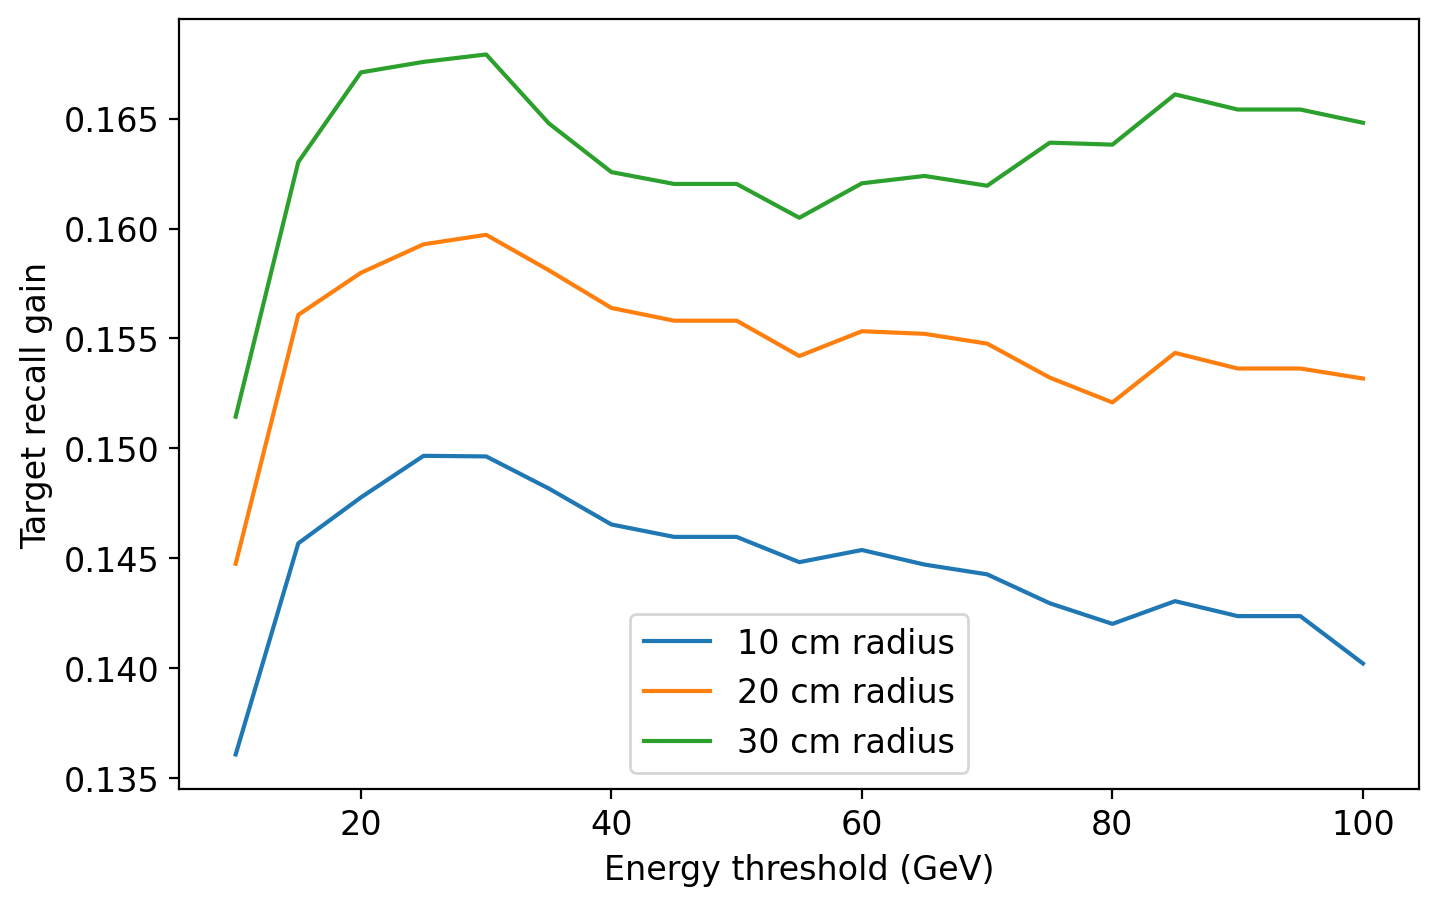

In [120]:
fig = plt.figure(figsize=(8, 5))

ax = fig.add_subplot(111)

for k, v in results.items():
    ax.plot(energy_list, v[0] - v[1], label=f"{k} cm radius")

ax.legend()
ax.set_xlabel("Energy threshold (GeV)")
ax.set_ylabel("Target recall gain")

fig.savefig('export/multiparticle-energy-plot.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

# Problems

Sometimes - if a simtrackster is too fragmented, it might not get selected as a big trackster
- we score 0.2 and at least 50% shared energy (or 50GeV)
- if trackster is too fragmented, it might not pass -> then its layerclusters might get stolen
- otherwise: multiple options might pass and then we need to resolve conflicts

In [19]:
clue3D_precision

[0.9745814129876775,
 0.13879720051511246,
 0.9745814129876775,
 0.13879720051511246,
 0.9745814129876775,
 0.13879720051511246,
 0.9745814129876775,
 0.13879720051511246,
 0.9745814129876775,
 0.13879720051511246,
 0.9745814129876775,
 0.13879720051511246,
 0.9745814129876775,
 0.13879720051511246,
 0.9745814129876775,
 0.13879720051511246,
 0.9745814129876775,
 0.13879720051511246,
 0.9745814129876775,
 0.13879720051511246]